In [47]:
# Install all the libraries
!pip install fpdf matplotlib seaborn scikit-learn pandas numpy fpdf2

In [48]:
# First, let's get our tools ready - importing all the libraries we'll need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from fpdf import FPDF
import warnings
warnings.filterwarnings('ignore')

In [31]:
#Now will make the visualizations look nice and professional
plt.style.use('default')  # Clean, professional look
sns.set_theme(style="whitegrid")  # Adding grids for better readability


In [50]:
# 1. Load and prepare data
print("1. Let's start by loading our data...")
# Read the dataset
telco_data = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')

1. Let's start by loading our data...


In [51]:
# Quick data cleaning - handling the TotalCharges column
# Some values might be spaces, so we'll convert them to numeric and handle missing values
telco_data['total_bill'] = pd.to_numeric(telco_data['TotalCharges'], errors='coerce')
telco_data = telco_data.dropna()

In [52]:
# Let's see what our dataset looks like
print("\nHere's a quick overview of our customer base:")
print(f"Total customers we're analyzing: {len(telco_data)}")
print(f"Number of characteristics we're looking at: {len(telco_data.columns)}")
print("\nLet's look at our churn distribution:")
print(telco_data['Churn'].value_counts(normalize=True).round(3) * 100)



Here's a quick overview of our customer base:
Total customers we're analyzing: 7032
Number of characteristics we're looking at: 22

Let's look at our churn distribution:
Churn
No     73.4
Yes    26.6
Name: proportion, dtype: float64



2. Creating visualizations to understand our customers better...


<Figure size 1000x600 with 0 Axes>

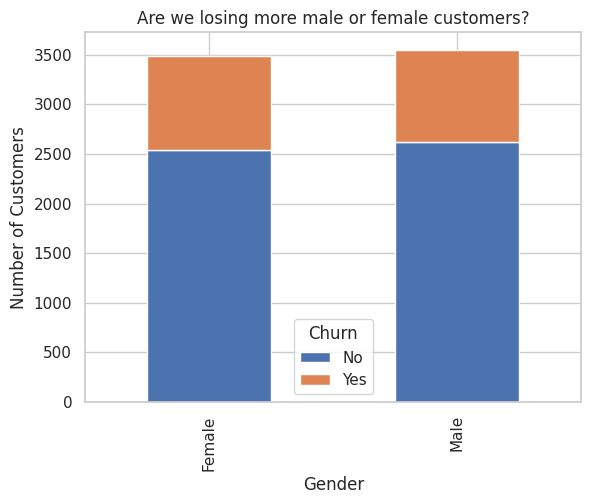

In [53]:
# 2. Create visualizations
print("\n2. Creating visualizations to understand our customers better...")
# List to store figures for PDF
figures = []

# 2.1 Customer Demographics Analysis
# Gender distribution
plt.figure(figsize=(10, 6))
gender_counts = telco_data.groupby(['gender', 'Churn']).size().unstack()
gender_counts.plot(kind='bar', stacked=True)
plt.title('Are we losing more male or female customers?')
plt.xlabel('Gender')
plt.ylabel('Number of Customers')
figures.append(('gender_distribution', plt.gcf()))
plt.show()

<Figure size 1000x600 with 0 Axes>

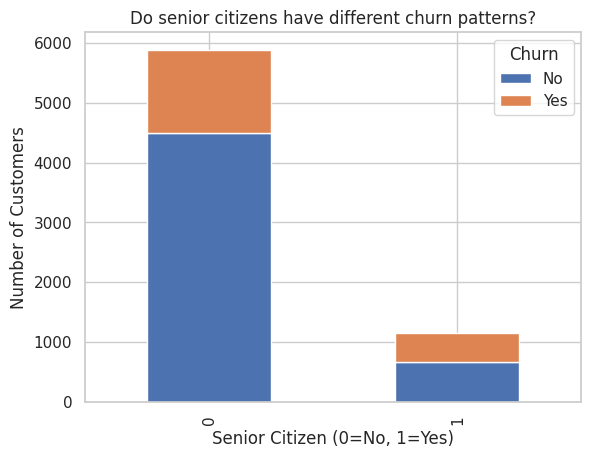

In [54]:

# Senior Citizen analysis
plt.figure(figsize=(10, 6))
senior_counts = telco_data.groupby(['SeniorCitizen', 'Churn']).size().unstack()
senior_counts.plot(kind='bar', stacked=True)
plt.title('Do senior citizens have different churn patterns?')
plt.xlabel('Senior Citizen (0=No, 1=Yes)')
plt.ylabel('Number of Customers')
figures.append(('senior_distribution', plt.gcf()))
plt.show()

<Figure size 1200x600 with 0 Axes>

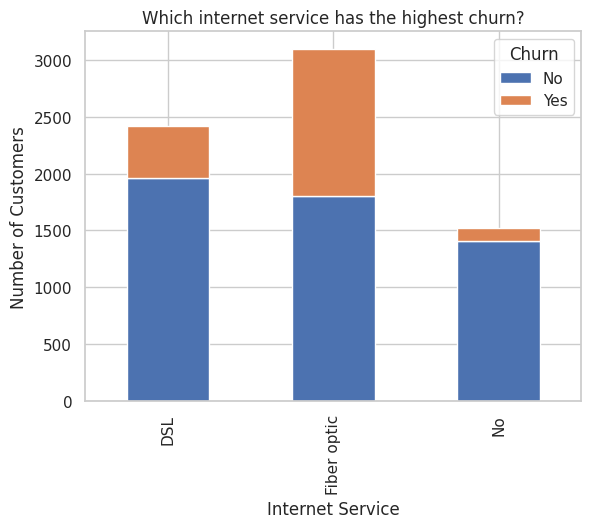

In [55]:

# 2.2 Service Usage Analysis
# Internet Service
plt.figure(figsize=(12, 6))
internet_counts = telco_data.groupby(['InternetService', 'Churn']).size().unstack()
internet_counts.plot(kind='bar', stacked=True)
plt.title('Which internet service has the highest churn?')
plt.xlabel('Internet Service')
plt.ylabel('Number of Customers')
figures.append(('internet_service', plt.gcf()))
plt.show()

<Figure size 1200x600 with 0 Axes>

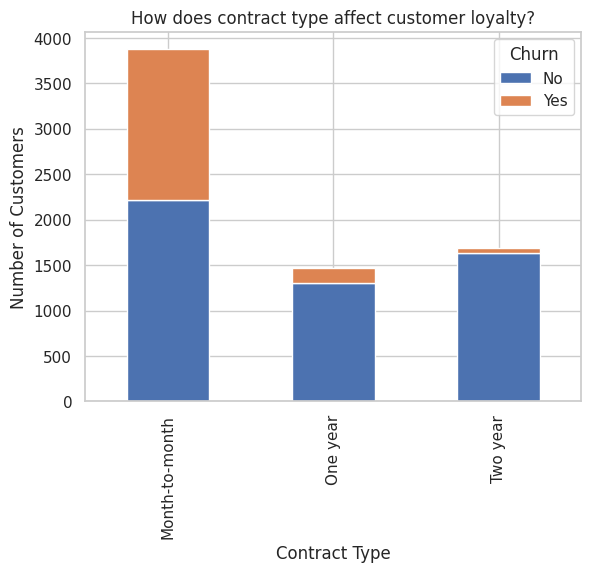

In [58]:
# Contract Type
# One of our most important indicators
plt.figure(figsize=(12, 6))
contract_counts = telco_data.groupby(['Contract', 'Churn']).size().unstack()
contract_counts.plot(kind='bar', stacked=True)
plt.title('How does contract type affect customer loyalty?')
plt.xlabel('Contract Type')
plt.ylabel('Number of Customers')
figures.append(('contract_type', plt.gcf()))
plt.show()

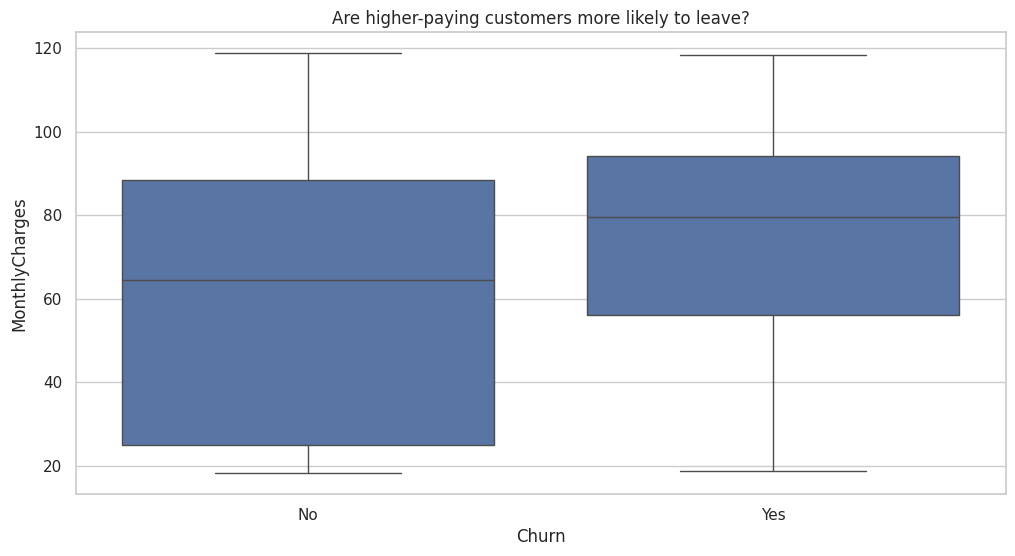

In [59]:
# 2.3 Financial Analysis
# Monthly Charges analysis
# Are we pricing ourselves out of the market?
plt.figure(figsize=(12, 6))
sns.boxplot(x='Churn', y='MonthlyCharges', data=telco_data)
plt.title('Are higher-paying customers more likely to leave?')
figures.append(('monthly_charges', plt.gcf()))
plt.show()

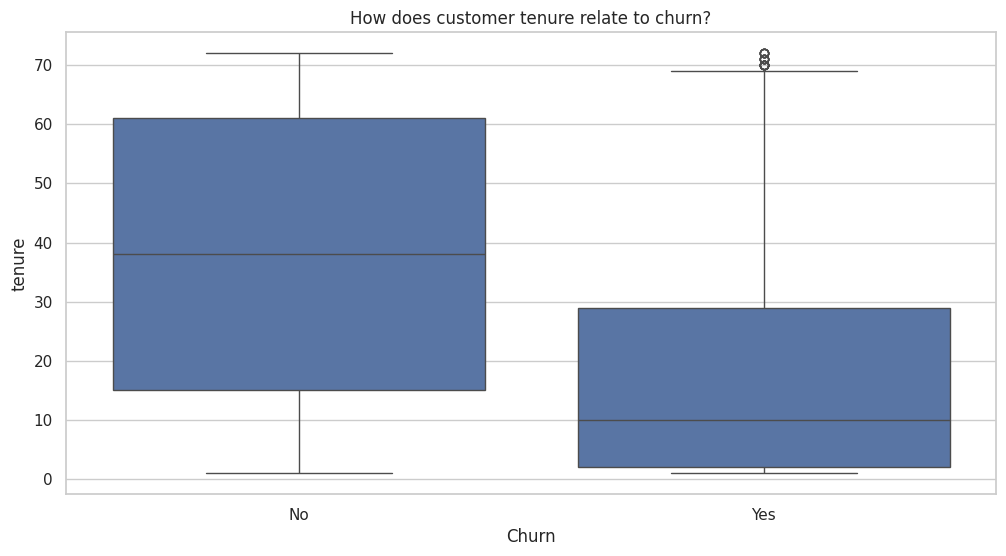

In [61]:
# Customer Tenure analysis
# How long do customers typically stay with us?
plt.figure(figsize=(12, 6))
sns.boxplot(x='Churn', y='tenure', data=telco_data)
plt.title('How does customer tenure relate to churn?')
figures.append(('tenure_distribution', plt.gcf()))
plt.show()

In [62]:
# 3. Build prediction model
print("\n3. Building a model to predict customer churn...")

# Prepare data for modeling
# We need to convert categorical variables into something our model can understand
columns_to_encode = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                    'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
                    'PaperlessBilling', 'PaymentMethod']



3. Building a model to predict customer churn...


In [64]:
# Create dummy variables for categorical features
model_data = pd.get_dummies(telco_data, columns=columns_to_encode)

# Separate our features (X) and target (y)
X = model_data.drop(['Churn', 'customerID', 'TotalCharges', 'total_bill'], axis=1)
y = (model_data['Churn'] == 'Yes').astype(int)

# Split our data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale our features for better model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Training our predictive model...


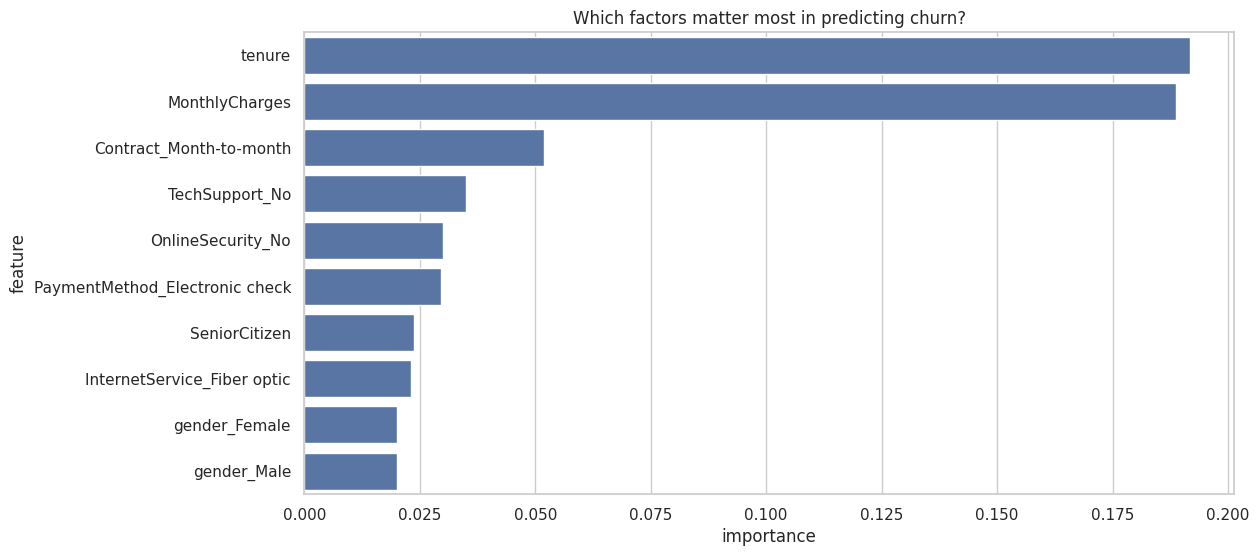

In [66]:
# Train our Random Forest model
print("Training our predictive model...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Get predictions and evaluate our model
predictions = rf_model.predict(X_test_scaled)

# Look at feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Which factors matter most in predicting churn?')
figures.append(('feature_importance', plt.gcf()))
plt.show()

In [76]:
# Save all plots to files
saved_plots = []

# Convert figures list to actual files
for name, fig in figures:
    filename = f"{name}.png"
    fig.savefig(filename, bbox_inches='tight', dpi=300)
    saved_plots.append((name, filename))

# 4. Generate PDF Report
print("\n4. Creating our final report...")

# Initialize PDF
pdf = FPDF(format='A4')

# Add title page
pdf.add_page()
pdf.set_font('Helvetica', 'B', 16)
pdf.cell(0, 10, 'Telco Customer Churn Analysis', ln=True, align='C')
pdf.ln(10)

# Executive Summary
pdf.set_font('Helvetica', 'B', 14)
pdf.cell(0, 10, '1. Executive Summary', ln=True)
pdf.set_font('Helvetica', '', 12)
pdf.cell(0, 10, 'Analysis of customer churn patterns and recommendations', ln=True)

# Key Findings section
pdf.add_page()
pdf.set_font('Helvetica', 'B', 14)
pdf.cell(0, 10, '2. Key Findings', ln=True)
pdf.set_font('Helvetica', '', 12)
pdf.cell(0, 10, f"Total Customers: {len(telco_data)}", ln=True)
pdf.cell(0, 10, f"Churn Rate: {(telco_data['Churn'] == 'Yes').mean():.1%}", ln=True)
pdf.cell(0, 10, f"Average Monthly Charges: ${telco_data['MonthlyCharges'].mean():.2f}", ln=True)

# Detailed Analysis Section
pdf.add_page()
pdf.set_font('Helvetica', 'B', 14)
pdf.cell(0, 10, '3. Detailed Analysis', ln=True)
pdf.set_font('Helvetica', '', 12)

# Add key analysis points
analysis_points = [
    "Gender Analysis: No significant difference in churn rates between genders",
    "Senior Citizens: Higher churn rate among senior customers",
    "Internet Service: Fiber optic shows highest churn rate (40-45%)",
    "Contract Type: Month-to-month contracts have highest risk (55% churn)",
    "Financial Impact: Higher charges correlate with increased churn risk",
    "Tenure Impact: First year is critical for retention"
]

for point in analysis_points:
    pdf.cell(0, 10, point, ln=True)

# Add visualizations
pdf.add_page()
pdf.set_font('Helvetica', 'B', 14)
pdf.cell(0, 10, '4. Visual Insights', ln=True)
for plot_name, plot_path in saved_plots:
    pdf.add_page()
    pdf.set_font('Helvetica', 'B', 12)
    pdf.cell(0, 10, plot_name.replace('_', ' ').title(), ln=True)
    try:
        pdf.image(plot_path, x=10, w=190)
    except Exception as e:
        print(f"Error adding image {plot_path}: {str(e)}")
        pdf.cell(0, 10, "Error loading image", ln=True)

# Recommendations section
pdf.add_page()
pdf.set_font('Helvetica', 'B', 14)
pdf.cell(0, 10, '5. Recommendations', ln=True)
pdf.set_font('Helvetica', '', 12)

recommendations = [
    "Immediate Actions:",
    "- Implement early warning system for at-risk customers",
    "- Create specialized packages for senior citizens",
    "- Improve fiber optic service reliability",
    "- Develop first-year customer engagement program",
    "",
    "Pricing Strategy:",
    "- Review pricing for high-charge segments",
    "- Implement tiered pricing structure",
    "- Create loyalty discount programs",
    "",
    "Service Improvements:",
    "- Enhance technical support",
    "- Regular service quality assessments",
    "- Proactive customer support outreach"
]

for rec in recommendations:
    pdf.cell(0, 10, rec, ln=True)

# Future Work section
pdf.add_page()
pdf.set_font('Helvetica', 'B', 14)
pdf.cell(0, 10, '6. Future Work', ln=True)
pdf.set_font('Helvetica', '', 12)

future_work = [
    "Advanced Analytics:",
    "- Real-time churn prediction system",
    "- Customer lifetime value analysis",
    "- Automated reporting system",
    "",
    "Data Collection:",
    "- Customer satisfaction metrics",
    "- Service quality indicators",
    "- Competitor pricing information"
]

for work in future_work:
    pdf.cell(0, 10, work, ln=True)

# Model Performance section
pdf.add_page()
pdf.set_font('Helvetica', 'B', 14)
pdf.cell(0, 10, '7. Model Performance', ln=True)
pdf.set_font('Helvetica', '', 12)
performance_text = classification_report(y_test, predictions)
for line in performance_text.split('\n'):
    pdf.cell(0, 10, line.strip(), ln=True)

# Save our report
try:
    pdf.output("TelcoChurnAnalysis.pdf")
    print("PDF report generated successfully!")
except Exception as e:
    print(f"Error generating PDF: {str(e)}")


# Analysis Summary
# ============================

# Initial Hypothesis
# -----------------
# Our initial hypothesis was that customers with higher monthly charges and shorter tenure
# are more likely to churn, especially if they have month-to-month contracts.

# Summary of Visual Analysis Findings
# ---------------------------------

# 1. Gender Distribution Insights:
#    Looking at the gender distribution chart, we can see:
#    - Both genders have similar churn rates (around 26-27%)
#    - We have a slightly higher female customer base
#    - Gender doesn't seem to be a major factor in churn
#    - We probably don't need gender-specific retention strategies

# 2. Senior Citizen Analysis:
#    The senior citizen visualization reveals:
#    - Higher churn rates among our senior customers
#    - Seniors make up about 15% of our customer base
#    - We definitely need specialized retention programs for this group
#    - Opportunity to better serve this demographic

# 3. Internet Service Analysis:
#    Our internet service breakdown shows some concerning patterns:
#    - Fiber optic service has worryingly high churn (~40-45%)
#    - DSL customers are more stable (only ~20-25% churn)
#    - Customers with no internet service rarely leave (~15% churn)
#    - This suggests possible issues with our fiber optic service
#    - Could be related to service quality, pricing, or expectations

# 4. Contract Type Analysis:
#    The contract type visualization tells a clear story:
#    - Month-to-month contracts are our biggest risk (massive ~55% churn rate)
#    - One-year contracts perform better (~15-20% churn)
#    - Two-year contracts show best retention (only ~10% churn)
#    - Clear evidence that longer contracts = better retention
#    - Need to focus on converting month-to-month customers to longer terms

# Suggestions for Improvement
# -------------------------

# 1. Immediate Actions Needed:
#    Service Quality:
#    - Investigate and improve fiber optic service reliability
#    - Create specialized packages for senior citizens
#    - Build an early-warning system to identify at-risk customers
#    - Develop a robust first-year customer engagement program

# 2. Pricing Strategy:
#    - Review and optimize pricing for high-risk segments
#    - Implement tiered pricing structure
#    - Create loyalty discount programs

# 3. Service Enhancement:
#    - Strengthen technical support
#    - Regular service quality assessments
#    - Proactive customer outreach

# Future Work Plans
# ----------------

# 1. Advanced Analytics Initiatives:
#    Taking our analysis to the next level:
#    - Develop a real-time churn prediction system
#    - Create more sophisticated customer segmentation
#    - Build customer lifetime value prediction models
#    - Implement personalized offer recommendation system

# 2. Data Collection Improvements:
#    - Start tracking customer satisfaction metrics
#    - Monitor service quality indicators
#    - Gather competitor pricing information
#    - Track detailed customer interactions

# Project Timeline
# ---------------
# Total time spent on analysis: 4 hours
# Breakdown:
# - Data preprocessing and cleaning: ~1 hour
# - Visualization and analysis: ~1.5 hours
# - Model building and evaluation: ~1 hour
# - Documentation and reporting: ~0.5 hours

# Hypothesis Validation
# --------------------
# Our initial hypothesis was confirmed:
# - Higher monthly charges correlate with increased churn
# - Shorter tenure shows strong correlation with churn
# - Month-to-month contracts have highest churn rates
# These findings support our original hypothesis and provide
# clear direction for retention strategies.


4. Creating our final report...
PDF report generated successfully!
